# Some ideas for DoE Tests

In [1]:
import math

import luxpy as lx
import numpy as np
from matplotlib import pyplot
import seaborn as sns
import pandas as pd

# temp import only
from empir19nrm02.Jupyter.jhelp import strd, label_font_size, plot_cmf2, save_fig, get_target, label_management, \
    quantil, display_responsivity, get_fig_file_name

%run -i jhelp

%matplotlib inline


from empir19nrm02.spectral import MCSpectrumSamples, generate_FourierMC0
from empir19nrm02.tools import plotHistScales, plotHistScalesWl, plotHistScalesValue, \
    array2analyse, analyse_stat, seaborn_plot_basedata, seaborn_plot_result, sumMC, sumMCV, plotCorrMatrixSmall
from empir19nrm02.f1prime import py_f1PrimeG,  py_f1PrimeGlx

from empir19nrm02 import _SPD, _RES

print('Version of luxpy:', lx.__version__)
out_dir = 'DoE'


Version of luxpy: v1.9.6


# Parameter for the simulation
#### Let's modify some standard data first and calculate some integrated values like $f_{1}^{'}$ and Yxy tristimulus values

In [2]:
strWeighting = 'A'
strObserver = '1931_2'
# let's use the V(Lambda) Function (0 ... X, 1...Y, 2...Z)
iObserverOffset = 1
wlResolution = 5
wlStart = 380
wlStop = 780
trials = 1000

bIdeal = False
bSimDetector = False    # True use RES for Simulation, False use SPD for simulation
selected_detector = 73
selected_SPD = 2 # 1=NLA, 2=L41

# MC Simulation
Define some data to work with (let's start with the $V(\lambda)$ function or a white PT-LED example)

In [3]:
lxCmf = lx._CMF['1931_2']
lxCmfInterpolate = lx.cie_interp(lxCmf['bar'], wl_new = np.arange(wlStart,wlStop+1,wlResolution), kind = 'S')
res = len(lxCmfInterpolate[0])

# Data storage
Take a nominal wavelength scale and the ideal detector/SPD and sore all together into a class instance SPD from luxpy

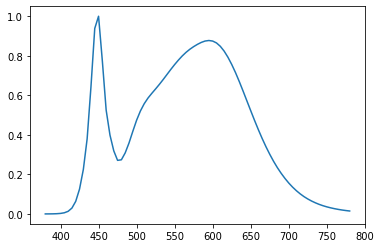

In [4]:
# Using a detector responsivity for the simulation
if bSimDetector:
    if bIdeal:
        # using an ideal detector
        wl=lxCmfInterpolate[0].reshape(1,res)
        value=lxCmfInterpolate[2].reshape(1,res)
        spd_init = np.r_[wl, value]
    else:
        # using an detector from the data base
        from empir19nrm02 import _RES
        wl= _RES['VLDetectors']['S']['data'][0].copy()
        value= _RES['VLDetectors']['S']['data'][selected_detector].copy()
        res_tmp = wl.shape[0]
        wl=wl.reshape(1,res_tmp)
        value=value.reshape(1,res_tmp)
        spd_org = np.r_[wl, value]
        spd_init = lx.cie_interp(spd_org, \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)
# Using a SD for the simulation
else:
    if bIdeal:
        # using an ideal SD (e.g. illumiant L)
        lxSpdInterpolate = lx.cie_interp(lx._CIE_ILLUMINANTS['LED_L41'], \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S')
        wl=lxSpdInterpolate[0].reshape(1,res)
        value=lxSpdInterpolate[1].reshape(1,res)
        spd_init = np.r_[wl, value]
    else:
        # using a ideal SD from the PhotoLED project
        from empir19nrm02 import _SPD
        wl= _SPD['PHOTOLED']['S']['data'][0].copy()
        value= _SPD['PHOTOLED']['S']['data'][selected_SPD].copy()
        res_tmp = wl.shape[0]
        wl=wl.reshape(1,res_tmp)
        value=value.reshape(1,res_tmp)
        spd_org = np.r_[wl, value]
        spd_init = lx.cie_interp(spd_org, \
            wl_new = np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)

spd_init[1,:]=spd_init[1,:]/np.max(spd_init[1,:])

pyplot.plot( spd_init[0],spd_init[1])


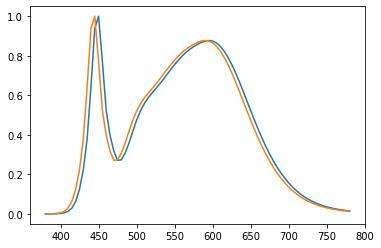

Yxy: [[5.3008e+04 3.7560e-01 3.7229e-01]]
Yxy_shift: [[5.3672e+04 3.6933e-01 3.7305e-01]]
Diff x: 0.006277686385961212, Diff y: -0.0007651383189191674


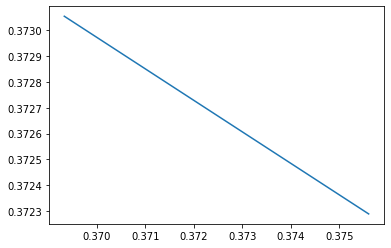

In [5]:
lxspd = lx.spd(spd_init)
XYZ = lx.spd_to_xyz( lxspd, relative=False, cieobs='1931_2')
Yxy = lx.xyz_to_Yxy (XYZ)


shift = 5
spd_wlshift = lx.cie_interp(spd_init, \
            wl_new = shift + np.arange(wlStart,wlStop+1,wlResolution),\
            kind = 'S',negative_values_allowed=True)
spd_wlshift[0] = spd_init[0]

pyplot.plot( spd_init[0],spd_init[1])
pyplot.plot( spd_wlshift[0],spd_wlshift[1])
pyplot.show()

XYZ_shift = lx.spd_to_xyz( spd_wlshift, relative=False, cieobs='1931_2')
Yxy_shift = lx.xyz_to_Yxy (XYZ_shift)

print('Yxy:', Yxy)
print('Yxy_shift:', Yxy_shift)
print(f'Diff x: {Yxy[0][1]-Yxy_shift[0][1]}, Diff y: {Yxy[0][2]-Yxy_shift[0][2]}')

pyplot.plot( [Yxy[0][1],Yxy_shift[0][1]],[Yxy[0][2],Yxy_shift[0][2]])


# Scale to reference?
* True:    all graphs will be shown as difference to the reference
* False:   all graphs will be shown as they are (without referencing the data)

In [6]:
scale_to_reference = True

# MC Steps?
All MC simulation include several steps (one step for every parameter in the model). The usage of these steps can be
selected here.

At the end, all selected parameters needs to be switched on together for the combined uncertainty.

The last version 'cov' means, that the simulation will be done based on the covaricane matrix and not based on the model
parameter variation.

In [7]:
mc_enable = { 'nothing': True,
              'wl_noise_nc': True,          # non correlated wavelength noise
              'wl_noise_c': True,           # correlated wavelength noise
              'wl_fourier_noise':True,      # fourier correlated wavelength noise
              'value_noise_nc': True,       # non correlated value noise
              'value_noise_c': True,        # correlated value noise
              'value_fourier_noise':True,   # fourier correlated value noise
              'all': True,                  # all components together
              'cov': False,                 # simulation based on the covariance matrix and multivariate gaussian noise only
              'file': False,                # simulation from a former simulation
              }

mc_disable = mc_enable.copy()
for key in mc_disable:
    mc_disable[key]=False

mc_cov = mc_disable.copy()
mc_cov['cov']=True

mc_file = mc_disable.copy()
mc_file['file']=True


In [8]:
def showResults( samples, name):
    print( samples.MCTable)
    samples.MCTable.to_excel(get_fig_file_name(dir=out_dir, filename= name + '.xlsx', table=True))

    v_wl_ref, v_wl, v_wl_diff, v_mean, v_mean_diff, v_std, q_min, q_max, cov_image, corr_image, counts = samples.get_result()

    fig, ax1 = pyplot.subplots()
    ax1.plot( v_wl_ref, v_mean, label=name+' mean')
    ax1.plot( v_wl_ref, v_std, label=name+' std')
    ax1.fill_between( v_wl_ref, q_min, q_max)
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel( 'mean; stddev / A.U.', fontsize=label_font_size)
    ax1.legend()
    save_fig(dir=out_dir, filename=name)

    fig, ax1 = pyplot.subplots()
    ax1.plot( v_wl_ref, v_mean_diff, label=name+' mean diff')
    ax1.plot( v_wl_ref, v_std, label=name+' stddev')
    ax1.fill_between( v_wl_ref, q_min-v_mean, q_max-v_mean)
    ax1.set_xlabel(strd['xlambda'], fontsize=label_font_size)
    ax1.set_ylabel( 'mean dif; stddev / A.U.', fontsize=label_font_size)
    ax1.legend()
    save_fig(dir=out_dir, filename=name+'Diff')

    plotCorrelation( cov_image, v_wl_ref, name + 'Covariance')
    save_fig(dir=out_dir, filename=name+'cov')

    plotCorrelation( corr_image, v_wl_ref, name + 'Correlation')
    save_fig(dir=out_dir, filename=name+'corr')

    return cov_image

In [9]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

# THX: https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, fill=False, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Running the MC simulation

# Generate a first MC Simulation
* take the initial spectral data (SD or responsivity)
* generate some noise on the value scale only
* run the MC simulation
* calculate statistical results
* save the data as csv and binary (okl) file
* show some results

nothing
generate_random_numbers
wl_noise_nc
generate_random_numbers
A
wl_noise_c
generate_random_numbers
B
wl_fourier_noise
generate_random_numbers
C
value_noise_nc
generate_random_numbers
D
value_noise_c
generate_random_numbers
E
value_fourier_noise
generate_random_numbers
F
all
generate_random_numbers
A
B
C
D
E
F
           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375631  1.042454e-03   
0           wl_noise_c    0    1.0  0       normal  0.375662  1.338214e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375578  1.820600e-03   
0       value_noise_nc    0   0.01  0       normal  0.375610  5.389943e-04   
0        value_noise_c    0   0.01  0       normal  0.375619  6.563238e-04   
0  value_fourier_noise    0   0.01  4            F  0.375630  9.449520e-04   
0                  all                              0.37580

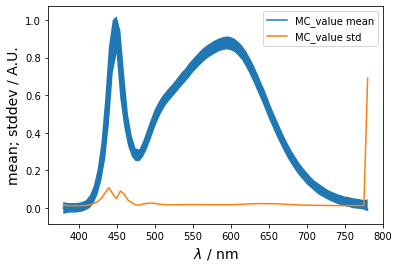

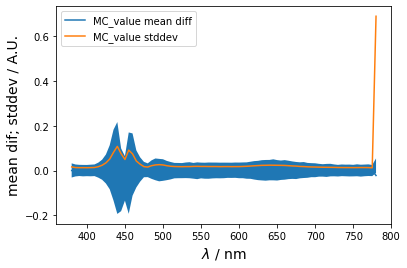

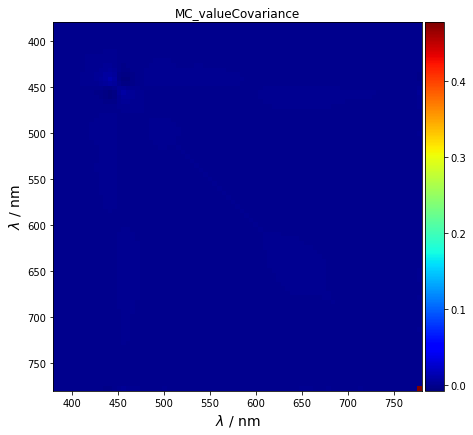

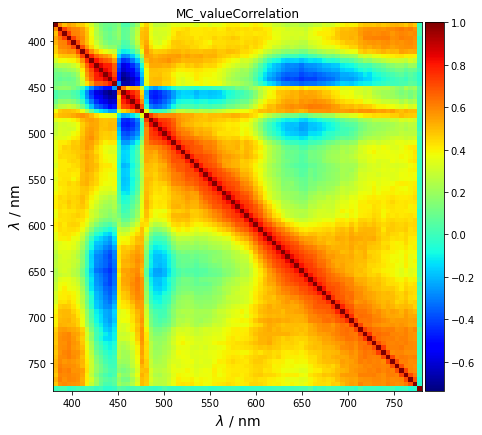

In [10]:
whished_results = ['x', 'y']
whished_results_str = [ 'x', 'y']

mcSpectrumSamples = MCSpectrumSamples(spd=spd_init, trials=trials)
mc_value = mc_enable.copy()
mcSpectrumSamples.run_MC(mc_value, whished_results)
mcSpectrumSamples.calc_summary(wavelength_stat=False)
mcSpectrumSamples.save_to_csv()
mcSpectrumSamples.save()

cov_image = showResults(mcSpectrumSamples, 'MC_value')

nothing
generate_random_numbers
wl_noise_nc
generate_random_numbers
A
wl_noise_c
generate_random_numbers
B
wl_fourier_noise
generate_random_numbers
C
value_noise_nc
generate_random_numbers
D
value_noise_c
generate_random_numbers
E
value_fourier_noise
generate_random_numbers
F
all
generate_random_numbers
A
B
C
D
E
F
           Contributon Mean StdDev NB Distribution         x            sx  \
0              nothing    0    0.0  0         none  0.375604  5.551115e-17   
0          wl_noise_nc    0    1.0  0       normal  0.375631  1.042454e-03   
0           wl_noise_c    0    1.0  0       normal  0.375662  1.338214e-03   
0     wl_fourier_noise    0    1.0  4            F  0.375578  1.820600e-03   
0       value_noise_nc    0   0.01  0       normal  0.375610  5.389943e-04   
0        value_noise_c    0   0.01  0       normal  0.375619  6.563238e-04   
0  value_fourier_noise    0   0.01  4            F  0.375630  9.449520e-04   
0                  all                              0.37580

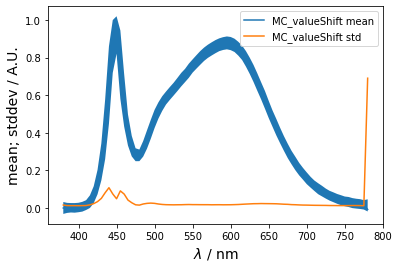

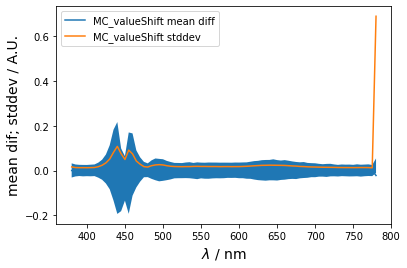

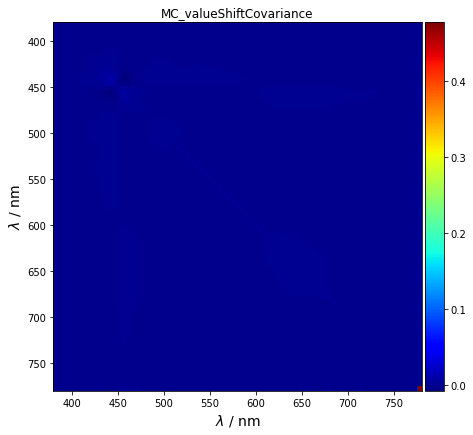

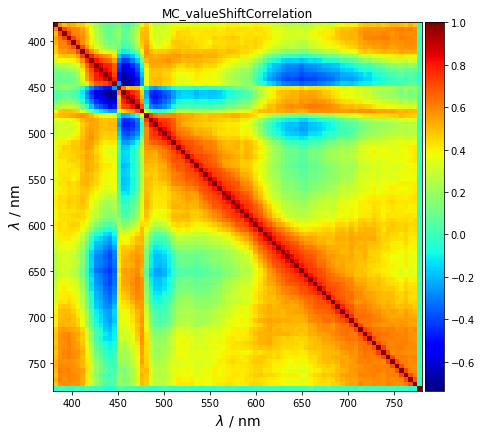

In [11]:
mcSpectrumSamples2 = MCSpectrumSamples(spd=spd_wlshift, trials=trials)
mc_value = mc_enable.copy()
mcSpectrumSamples2.run_MC(mc_value, whished_results)
mcSpectrumSamples2.calc_summary(wavelength_stat=False)
mcSpectrumSamples2.save_to_csv()
mcSpectrumSamples2.save()

cov_image = showResults(mcSpectrumSamples, 'MC_valueShift')

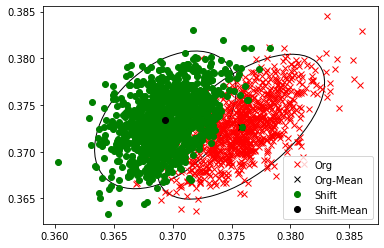

In [12]:
fig, ax1 = pyplot.subplots()
ax1.plot(mcSpectrumSamples.spectrumResults.result['x']['data'],mcSpectrumSamples.spectrumResults.result['y']['data'], 'rx' , label = 'Org')
ax1.plot(mcSpectrumSamples.spectrumResults.result['x']['Mean'],mcSpectrumSamples.spectrumResults.result['y']['Mean'], 'kx' , label = 'Org-Mean')
confidence_ellipse(mcSpectrumSamples.spectrumResults.result['x']['data'],mcSpectrumSamples.spectrumResults.result['y']['data'], ax1, n_std=2.45, facecolor='k')
ax1.plot(mcSpectrumSamples2.spectrumResults.result['x']['data'],mcSpectrumSamples2.spectrumResults.result['y']['data'] , 'go', label = 'Shift')
ax1.plot(mcSpectrumSamples2.spectrumResults.result['x']['Mean'],mcSpectrumSamples2.spectrumResults.result['y']['Mean'], 'ko' , label = 'Shift-Mean')
confidence_ellipse(mcSpectrumSamples2.spectrumResults.result['x']['data'],mcSpectrumSamples2.spectrumResults.result['y']['data'], ax1, n_std=2.45, facecolor='k')
ax1.legend()

In [13]:
x1 = np.array((mcSpectrumSamples.spectrumResults.result['x']['Mean'],mcSpectrumSamples.spectrumResults.result['y']['Mean']))
data_x1 = np.array((mcSpectrumSamples.spectrumResults.result['x']['data'],mcSpectrumSamples.spectrumResults.result['y']['data']))
cov1 = mcSpectrumSamples.spectrumResults.get_table_covariane(['x', 'y'])
x2 = np.array((mcSpectrumSamples2.spectrumResults.result['x']['Mean'],mcSpectrumSamples2.spectrumResults.result['y']['Mean']))
data_x2 = np.array((mcSpectrumSamples2.spectrumResults.result['x']['data'],mcSpectrumSamples2.spectrumResults.result['y']['data']))
cov2 = mcSpectrumSamples2.spectrumResults.get_table_covariane(['x', 'y'])

print( x1, cov1)
print( x2, cov2)

[3.7580e-01 3.7268e-01] [[8.3895e-06 5.5877e-06]
 [5.5877e-06 1.0022e-05]]
[3.6938e-01 3.7341e-01] [[6.0072e-06 3.1728e-06]
 [3.1728e-06 9.0503e-06]]


chisquare: 6
[6.4252e-03 -7.2934e-04]
[[1.4397e-05 8.7605e-06]
 [8.7605e-06 1.9072e-05]]
Difference: [6.4252e-03 -7.2934e-04] Norm: 0.006466492533974252
dy: 0.007522434231654926
d
0.006425230776161528 -0.0007293388547249258


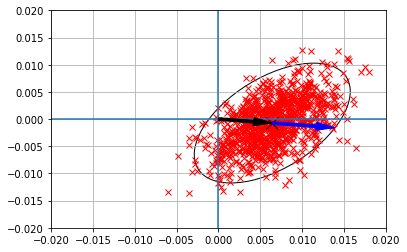

In [22]:
d = x1-x2
data = data_x1-data_x2
V=cov1+cov2

from numpy.linalg import norm, inv
from scipy.stats import chi2

chisquare = chi2.pdf(0.05, df=2)
chisquare = 6
print('chisquare:', chisquare)
print(d)
print(V)
d_norm = norm(d)
print('Difference:', d, 'Norm:', d_norm)
d_y = math.sqrt(1./(d.T @ inv(V) @ d)*chisquare)
print('dy:', d_y*d_norm)

fig, ax1 = pyplot.subplots()
ax1.plot(data[0], data[1], 'rx' , label = 'Difference')
ax1.plot(d[0], d[1], 'kx' , label = 'Difference', markersize=12)
confidence_ellipse(data[0],data[1], ax1, n_std=2.45, facecolor='k')
ax1.axvline(0)
ax1.axhline(0)
ax1.set_xlim([-0.02, 0.02])
ax1.set_ylim([-0.02, 0.02])
ax1.grid()
print('d')
print(d[0], d[1])
ax1.arrow(0,0, d[0], d[1], width=.0005, color='black', length_includes_head=True, zorder=100)
fakt = d_y*d_norm/norm(d)
ax1.arrow(d[0],d[1], fakt*d[0], fakt*d[1], width=.0005, color='blue', length_includes_head=True, zorder=100)

In [15]:
XXX

NameError: name 'XXX' is not defined

In [ ]:
mcSpectrumSamples.spectrumResults.seaborn_plot( whished_results, whished_results_str=whished_results_str, title='Value noise')
save_fig(dir=out_dir, filename='MC_Value_seaborn')

res_corr=mcSpectrumSamples.spectrumResults.get_table_correlation( whished_results)
print( res_corr)
plotCorrMatrixSmall(res_corr, whished_results_str, title=None, fileName=None, with_values=True)

# Load the data from the first MC Simulation
* Load csv or binary data from the first MC Simulation
* Recalculate the statistical data
* show some results (and the difference to the original evaluation)

In [ ]:
# decide load_csv=True (load data from csv and generate the MC Samples with a multivariante normal distribution) or
#        load_csv=False (load the data from pkl-File and generate only the evaluation a second time based on the same
#                       spectral distributions)
#                       The difference in the cov/corr matrixes should be zero in this case
load_csv = False

mcSpectrumSamples2 = MCSpectrumSamples(spd=spd_init, trials=trials)
if load_csv:
    mcSpectrumSamples2.run_MC(mc_cov, whished_results, filename='MCSpectrumSamples')
else:
    mcSpectrumSamples2.run_MC(mc_file, whished_results, filename='MCSpectrumSamples')

mcSpectrumSamples2.calc_summary(wavelength_stat=False)
mcSpectrumSamples2.save_to_csv()
mcSpectrumSamples2.save()

cov_image2=showResults(mcSpectrumSamples2, 'MC_value_load')

# there should be no (using binary data) or only smal differences (unsing csv data)
plotCorrelation( cov_image - cov_image2, spd_init[0], 'Covariance Diff 1-2')

print( 'Mean cov diff:', np.mean(np.abs(cov_image - cov_image2)))

In [ ]:
mcSpectrumSamples2.spectrumResults.seaborn_plot( whished_results, whished_results_str=whished_results_str, title='Value noise')
save_fig(dir=out_dir, filename='MC_Value_load_seaborn')

res_corr2=mcSpectrumSamples2.spectrumResults.get_table_correlation( whished_results)
print( res_corr2)
plotCorrMatrixSmall(res_corr2, whished_results_str, title=None, fileName=None, with_values=True)

# Generate a second MC Simulation
* take the initial spectral data (SD or responsivity)
* generate some noise on the _wavelength_ scale only
* run the MC simulation
* calculate statistical results
* save the data as csv and binary (okl) file
* show some results
* interploate the data to the nominal wl-scale
* show the resutls again

In [ ]:
mcSpectrumSamples3 = MCSpectrumSamples(spd=spd_init, trials=trials)
mc_wl = mc_disable.copy()
mc_wl['wl_noise_c']=True
mc_wl['wl_noise_nc']=True
mc_wl['wl_fourier_noise']=True
mc_wl['all']=True

mcSpectrumSamples3.run_MC(mc_wl, whished_results)
mcSpectrumSamples3.calc_summary(wavelength_stat=True)
print( mcSpectrumSamples3.MCTable)
mcSpectrumSamples3.MCTable.to_excel(get_fig_file_name(dir=out_dir, filename='MC_TableValue3.xlsx', table=True))

mcSpectrumSamples3.save_to_csv()
mcSpectrumSamples3.save()

cov_image3=showResults(mcSpectrumSamples3, 'MC_wl')

In [ ]:
mcSpectrumSamples3.spectrumResults.seaborn_plot( whished_results, whished_results_str=whished_results_str, title='wl noise')
save_fig(dir=out_dir, filename='MC_wl_Seaborn')

res_corr3=mcSpectrumSamples.spectrumResults.get_table_correlation( whished_results)
print( res_corr3)
plotCorrMatrixSmall(res_corr3, whished_results_str, title=None, fileName=None, with_values=True)

In [ ]:
mcSpectrumSamples4 = MCSpectrumSamples(spd=spd_init, trials=trials)
mc_all = mc_enable.copy()

mcSpectrumSamples4.run_MC(mc_all, whished_results)
mcSpectrumSamples4.calc_summary(wavelength_stat=False)
print( mcSpectrumSamples4.MCTable)
mcSpectrumSamples4.MCTable.to_excel(get_fig_file_name(dir=out_dir, filename='MC_TableValue4.xlsx', table=True))

mcSpectrumSamples4.save_to_csv()
mcSpectrumSamples4.save()

cov_image4=showResults(mcSpectrumSamples4, 'MC_all')

In [ ]:
mcSpectrumSamples4.spectrumResults.seaborn_plot( whished_results, whished_results_str=whished_results_str, title='all noise')
save_fig(dir=out_dir, filename='MC_all_Seaborn')

res_corr4=mcSpectrumSamples.spectrumResults.get_table_correlation( whished_results)
print( res_corr4)
plotCorrMatrixSmall(res_corr4, whished_results_str, title=None, fileName=None, with_values=True)

In [ ]:
def FourierTableP( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))
    start_data =np.r_[ wl.reshape(1,wl.shape[0]), SPD.reshape(1,wl.shape[0])]
    XYZ = lx.spd_to_xyz( start_data, relative=False, cieobs='1931_2')
    Yxy = lx.xyz_to_Yxy (XYZ)
    print( Yxy)
    x0 = Yxy[0,1]
    y0 = Yxy[0,2]
    L0 = Yxy[0,0]
    CCT0 = lx.xyz_to_cct(XYZ)[0,0]
    print( CCT0)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        XYZ = lx.spd_to_xyz( tmp_data, relative=False, cieobs='1931_2')
        Yxy = lx.xyz_to_Yxy (XYZ)
        xData = Yxy[:, 1]
        yData = Yxy[:, 2]
        L = Yxy[:, 0]
        CCT = lx.xyz_to_cct(XYZ)
        CCT.resize(trials)
        # Luminance
        [Lvalues, Linterval] = sumMC(L / L0, Coverage=0.95)
        #CCT
        [CCTvalues, CCTinterval] = sumMC(CCT, Coverage=0.95)
        #(x,y)
        [xvalues, xinterval] = sumMC(xData, Coverage=0.95)
        [yvalues, yinterval] = sumMC(yData, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'dL_mean': Lvalues[0], 'L_std': Lvalues[1], 'L_95%': (Linterval[1]-Linterval[0])/2., \
            'dCCT_mean': (CCTvalues[0]-CCT0), 'CCT_std': CCTvalues[1], 'CCT_95%': (CCTinterval[1] - CCTinterval[0]) / 2., \
            'dx_mean': xvalues[0]-x0, 'x_std': xvalues[1], 'x_95%': (xinterval[1] - xinterval[0]) / 2., \
            'dy_mean': yvalues[0]-y0, 'y_std': yvalues[1], 'x_95%': (yinterval[1] - yinterval[0]) / 2., \
             } , dtype = 'float')

        petriTable = pd.concat( [petriTable, df])
        print( numberNew)
    return petriTable


def FourierTablef1p( trials, wl, SPD, uSPD):
    elements2Run = [0,1,2,3,4,5,6,7,8,9,10,20,30,40,42, 50,60,70,80,90,100,150,200,235]
    petriTable = pd.DataFrame()
    rMatrixSPD = np.zeros((trials, wl.shape[0]))

    start_data =np.r_[ wl.reshape(1,wl.shape[0]), SPD.reshape(1,wl.shape[0])]
    f1p0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pE0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pL0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
    f1pMin0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
    f1ppR0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)
    f1pBW0=py_f1PrimeGlx(start_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0, dBandWidth=20.)
    for i, numberNew in enumerate(elements2Run):
        for j in range(trials):
            rMatrix=generate_FourierMC0( numberNew, wl, uSPD)
            rMatrixSPD[j] = (1+rMatrix)*SPD
        tmp_data =np.r_[ wl.reshape(1,wl.shape[0]), rMatrixSPD]
        f1p=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pE=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pL=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='LED_B3', iMin=0, dCutOff=0., dBandWidth=0.)
        f1pMin=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=1, dCutOff=0., dBandWidth=0.)
        f1ppR=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='E', iMin=0, dCutOff=-0.003, dBandWidth=0.)
        f1pBW=py_f1PrimeGlx(tmp_data, strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0, dBandWidth=20.)

        [f1p_values, f1p_interval] = sumMC(f1p, Coverage=0.95)
        [f1pE_values, f1pE_interval] = sumMC(f1pE, Coverage=0.95)
        [f1pL_values, f1pL_interval] = sumMC(f1pL, Coverage=0.95)
        [f1pMin_values, f1pMin_interval] = sumMC(f1pMin, Coverage=0.95)
        [f1ppR_values, f1ppR_interval] = sumMC(f1ppR, Coverage=0.95)
        [f1pBW_values, f1pBW_interval] = sumMC(f1pBW, Coverage=0.95)
        df = pd.DataFrame( { \
            'N': [numberNew], \
            'df1p': f1p_values[0]-f1p0, 'f1p_std': f1p_values[1], 'f1p_95%': (f1p_interval[1]-f1p_interval[0])/2., \
            'df1pE': f1pE_values[0]-f1pE0, 'f1pE_std': f1pE_values[1], 'f1pE_95%': (f1pE_interval[1]-f1pE_interval[0])/2., \
            'df1pL': f1pL_values[0]-f1pL0, 'f1pL_std': f1pL_values[1], 'f1pL_95%': (f1pL_interval[1]-f1pL_interval[0])/2., \
            'df1pMin': f1pMin_values[0]-f1pMin0, 'f1pMin_std': f1pMin_values[1], 'f1pMin_95%': (f1pMin_interval[1]-f1pMin_interval[0])/2., \
            'df1ppR': f1ppR_values[0]-f1ppR0, 'f1ppR_std': f1ppR_values[1], 'f1ppR_95%': (f1ppR_interval[1]-f1ppR_interval[0])/2., \
            'df1pBW': f1pBW_values[0]-f1pBW0, 'f1pBW_std': f1pBW_values[1], 'f1pBW_95%': (f1pBW_interval[1]-f1pBW_interval[0])/2., \
             } , dtype = 'float')
        petriTable = pd.concat([petriTable,df])
        print( numberNew)
    return petriTable

In [ ]:
res_VL = spd_init[0].shape[0]
uSPD=np.zeros(res_VL)
uSPD[:]=0.01

In [ ]:
print( 'FourierTableP')
petriTableP=FourierTableP(100, spd_init[0], spd_init[1], uSPD)
petriTableP
petriTableP.to_excel(get_fig_file_name(dir=out_dir, filename='FourierP.xlsx', table=True))

In [ ]:
[f1pOrg, _]=py_f1PrimeG(spd_init[0], spd_init[1], strObserver='1931_2', iObserverOffset = 1, strWeighting='A', iMin=0, dCutOff=0., dBandWidth=0.)
print('f1pOrg=', f1pOrg)

print( 'FourierTablef1p')
petriTable=FourierTablef1p(100, spd_init[0], spd_init[1], uSPD)
petriTable
petriTable.to_excel(get_fig_file_name(dir=out_dir, filename='Fourierf1p.xlsx', table=True))

In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="df1p", marker='o', color="Red", label="$\Delta f_{1}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pE", marker='x', color="Red", label="$\Delta f_{1,\mathrm{E}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pL", marker='1', color="Red", label="$\Delta f_{1,\mathrm{L}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pMin", marker='<', color="Red", label="$\Delta f_{1,\mathrm{Min}}^{´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1ppR", marker='>', color="Blue", label="$\Delta f_{1,\mathrm{R}}^{´´}$", ax=ax1)
petriTable.plot.scatter(x="N", y="df1pBW", marker='2', color="Blue", label="$\Delta f_{1,\mathrm{BW}}^{´}$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$\Delta f_{1}^{´}, \Delta f_{1,\mathrm{E}}^{´}, \Delta f_{1,\mathrm{L}}^{´},  \Delta f_{1,\mathrm{Min}}^{´}, \Delta f_{1,\mathrm{R}}^{´´}, \Delta f_{1,\mathrm{BW}}^{´} $', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='f1pTableFourier')


In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
petriTable.plot.scatter(x="N", y="f1p_95%", marker='o', color="Red", label="U($f_{1}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pE_95%", marker='x', color="Red", label="U($f_{1, \mathrm{E}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pL_95%", marker='1', color="Red", label="$U(f_{1,\mathrm{L}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pMin_95%", marker='<', color="Red", label="U($f_{1, \mathrm{Min}}^{´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1ppR_95%", marker='>', color="Blue", label="$U(f_{1,\mathrm{R}}^{´´})$", ax=ax1)
petriTable.plot.scatter(x="N", y="f1pBW_95%", marker='2', color="Blue", label="$U(f_{1,\mathrm{BW}}^{´})$", ax=ax1)
ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$U(f_{1}^{´}), U(f_{1,\mathrm{E}}^{´}), U(f_{1,\mathrm{L}}^{´}),  U(f_{1,\mathrm{Min}}^{´}), U(f_{1,\mathrm{R}}^{´´}), U(f_{1,\mathrm{BW}}^{´})$', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='Uf1pTableFourier')

In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
#petriTableP.plot.scatter(x="N", y="dL_mean", marker='o', color="Red", label="$\Delta Y$", ax=ax1)
petriTableP.plot.scatter(x="N", y="dx_mean", marker='x', color="Red", label="$\Delta x$", ax=ax1)
petriTableP.plot.scatter(x="N", y="dy_mean", marker='1', color="Red", label="$\Delta y$", ax=ax1)
ax2 = ax1.twinx()
petriTableP.plot.scatter(x="N", y="dCCT_mean", marker='<', color="Red", label="$\Delta CCT$", ax=ax2)
ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$\Delta Y, \Delta x, \Delta y, \Delta CCT $', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='PTableFourier')


In [ ]:
fig, ax1 = pyplot.subplots(figsize=(10,7))
#petriTableP.plot.scatter(x="N", y="L_std", marker='o', color="Red", label="$u(Y)$", ax=ax1)
petriTableP.plot.scatter(x="N", y="x_std", marker='x', color="Red", label="$u(x)$", ax=ax1)
petriTableP.plot.scatter(x="N", y="y_std", marker='1', color="Red", label="$u(y)$", ax=ax1)
ax2 = ax1.twinx()
petriTableP.plot.scatter(x="N", y="CCT_std", marker='<', color="Red", label="$u(CCT)$", ax=ax2)

ax1.set_xlabel('$N_{\mathrm{B}}$', fontsize=label_font_size)
ax1.set_ylabel('$U(f_{1}^{´}), U(f_{1,\mathrm{E}}^{´}), U(f_{1,\mathrm{L}}^{´}),  U(f_{1,\mathrm{Min}}^{´}), U(f_{1,\mathrm{R}}^{´´}), U(f_{1,\mathrm{BW}}^{´})$', fontsize=label_font_size)
ax1.set_xlim([0,50])

save_fig(dir=out_dir, filename='UPTableFourier')
